##Predicting if a Patient has Diabetes Using Logistic Regression

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases, but downloaded it from Kaggle.com. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Features:

Pregnancies: Number of times pregnant

Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

BloodPressure: Diastolic blood pressure (mm Hg)

SkinThickness: Triceps skin fold thickness (mm)

Insulin: 2-Hour serum insulin (mu U/ml)

BMI: Body mass index (weight in kg/(height in m)^2)

DiabetesPedigreeFunction: Diabetes pedigree function

Age: Age (years)

Outcome: Class variable (0 or 1)
- zero is not having diabetes, 1 is having diabetes 


Project Objective: Use Logistic Regression Algorithm to Determine if a Patient has Diabetes or Not Based on Multiple Features.

In [0]:
display(dbutils.fs.ls("dbfs:/FileStore/tables/diabetes"))

path,name,size,modificationTime
dbfs:/FileStore/tables/diabetes/diabetes.csv,diabetes.csv,23873,1668115307000


In [0]:
# input data set 
df = spark.read.format("csv").load("dbfs:/FileStore/tables/diabetes/diabetes.csv",  inferSchema="true", header="true")
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [0]:
# View the Column Names and Data Types
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [0]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


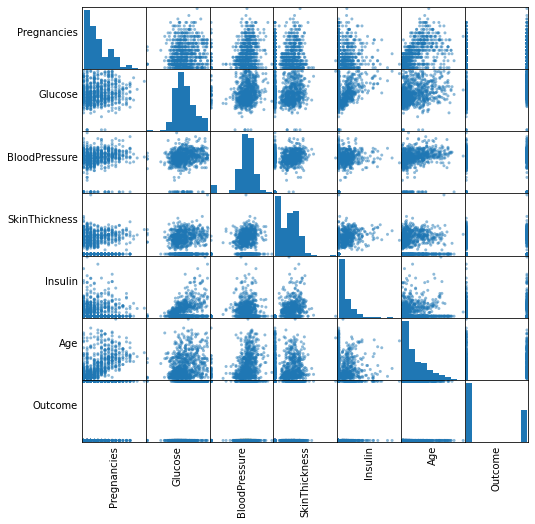

In [0]:
#Create a Scatter Matrix to See if Features are Coorelated
from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [0]:
# Drop columns which are not required
df1 = df.drop("SkinThickness","Insulin","DiabetesPedigreeFunction", 'Pregnancies')
df1.show()

+-------+-------------+----+---+-------+
|Glucose|BloodPressure| BMI|Age|Outcome|
+-------+-------------+----+---+-------+
|    148|           72|33.6| 50|      1|
|     85|           66|26.6| 31|      0|
|    183|           64|23.3| 32|      1|
|     89|           66|28.1| 21|      0|
|    137|           40|43.1| 33|      1|
|    116|           74|25.6| 30|      0|
|     78|           50|31.0| 26|      1|
|    115|            0|35.3| 29|      0|
|    197|           70|30.5| 53|      1|
|    125|           96| 0.0| 54|      1|
|    110|           92|37.6| 30|      0|
|    168|           74|38.0| 34|      1|
|    139|           80|27.1| 57|      0|
|    189|           60|30.1| 59|      1|
|    166|           72|25.8| 51|      1|
|    100|            0|30.0| 32|      1|
|    118|           84|45.8| 31|      1|
|    107|           74|29.6| 31|      1|
|    103|           30|43.3| 33|      0|
|    115|           70|34.6| 32|      1|
+-------+-------------+----+---+-------+
only showing top

In [0]:
# Assemble all the features with VectorAssembler
required_features = ['Glucose',
                    'BloodPressure',
                    'BMI',
                    'Age'
                   ]

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=required_features, outputCol='features')

transformed_data = assembler.transform(df1)
transformed_data.show()

+-------+-------------+----+---+-------+--------------------+
|Glucose|BloodPressure| BMI|Age|Outcome|            features|
+-------+-------------+----+---+-------+--------------------+
|    148|           72|33.6| 50|      1|[148.0,72.0,33.6,...|
|     85|           66|26.6| 31|      0|[85.0,66.0,26.6,3...|
|    183|           64|23.3| 32|      1|[183.0,64.0,23.3,...|
|     89|           66|28.1| 21|      0|[89.0,66.0,28.1,2...|
|    137|           40|43.1| 33|      1|[137.0,40.0,43.1,...|
|    116|           74|25.6| 30|      0|[116.0,74.0,25.6,...|
|     78|           50|31.0| 26|      1|[78.0,50.0,31.0,2...|
|    115|            0|35.3| 29|      0|[115.0,0.0,35.3,2...|
|    197|           70|30.5| 53|      1|[197.0,70.0,30.5,...|
|    125|           96| 0.0| 54|      1|[125.0,96.0,0.0,5...|
|    110|           92|37.6| 30|      0|[110.0,92.0,37.6,...|
|    168|           74|38.0| 34|      1|[168.0,74.0,38.0,...|
|    139|           80|27.1| 57|      0|[139.0,80.0,27.1,...|
|    189

In [0]:
# Split the data
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2], seed =2020)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 620
Test Dataset Count: 148


In [0]:
#logistic regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'Outcome', maxIter=10)
lrModel = lr.fit(training_data)
lr_predictions = lrModel.transform(test_data)

In [0]:
# Determine Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Outcome', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator.evaluate(lr_predictions))

Logistic Regression Accuracy: 0.777027027027027



The Logistic Regression Model Predicting Diabetes Based on Glucose, Blood Pressure, BMI and Age has an accuracy rate of 77%

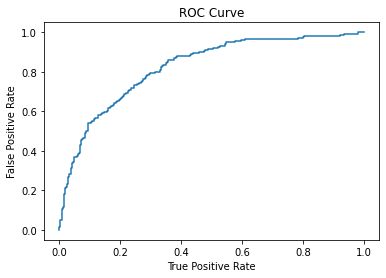

Training set areaUnderROC: 0.8233161456654885


In [0]:
# Evaluate the Model With ROC Curve
import matplotlib.pyplot as plt

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


ROC curves plot the true positive rate and the false positive rate. A higher AUC is a good measure of predictive accuracy. The area under the ROC curve for this model is 0.82

In [0]:
#Predict
predictions = lrModel.transform(test_data)
predictions.select('Glucose',  'BloodPressure', 'BMI', 'Age', 'probability').show(10)

+-------+-------------+----+---+--------------------+
|Glucose|BloodPressure| BMI|Age|         probability|
+-------+-------------+----+---+--------------------+
|     57|           80|32.8| 41|[0.93869581088906...|
|     67|           76|45.3| 46|[0.75154464358834...|
|     71|           48|20.4| 22|[0.97212697809202...|
|     71|           78|33.2| 21|[0.94826215263627...|
|     72|           78|31.6| 38|[0.91844478142981...|
|     76|           60|32.8| 41|[0.86240622828719...|
|     78|           50|31.0| 26|[0.90950485783267...|
|     78|           88|36.9| 21|[0.92440827645281...|
|     84|           64|35.8| 21|[0.88802643389152...|
|     84|           82|38.2| 23|[0.88548757595261...|
+-------+-------------+----+---+--------------------+
only showing top 10 rows



In [0]:
predictions.createOrReplaceTempView("finalPredictions")

In [0]:
%sql
SELECT age, prediction, count(*) AS count
FROM finalPredictions
GROUP BY age, prediction
ORDER BY age

age,prediction,count
21,0.0,17
22,0.0,9
22,1.0,1
23,0.0,9
23,1.0,2
24,1.0,2
24,0.0,3
25,0.0,7
26,0.0,3
26,1.0,1


Databricks visualization. Run in Databricks to view.


Above is a graph of the predicted result of Not Having Diabetes(0) or Having Diabetes (1) compared with age. Focusing on not having diabetes (blue -2), the rate goes down as age increases. However, it appears that having diabetes (red - 1), has a bimodal distribution; as it peaks at both ages 28 and 41 and they have higher rates of having diabetes than other ages. 